<!-- # %% [markdown] -->
# 1. Generate diffraction simulations


<name: 1009012. space group: Fmmm. point group: mmm. proper point group: 222. color: tab:blue>
lattice=Lattice(a=4.428, b=4.779, c=9.078, alpha=90, beta=90, gamma=90)
Ti   0.000000 0.000000 0.000000 1.0000
Ti   0.000000 0.500000 0.500000 1.0000
Ti   0.500000 0.000000 0.500000 1.0000
Ti   0.500000 0.500000 0.000000 1.0000
Si   0.000000 0.000000 0.322000 1.0000
Si   0.000000 0.000000 0.678000 1.0000
Si   0.000000 0.500000 0.822000 1.0000
Si   0.500000 0.000000 0.822000 1.0000
Si   0.500000 0.500000 0.322000 1.0000
Si   0.000000 0.500000 0.178000 1.0000
Si   0.500000 0.000000 0.178000 1.0000
Si   0.500000 0.500000 0.678000 1.0000


1009012: 100%|██████████| 271/271 [00:01<00:00, 222.08it/s]
INFO - Generated 271 patterns.


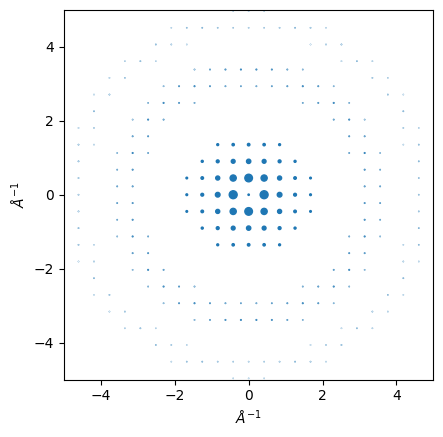

In [36]:
# %%
from pathlib import Path
import logging

from orix.crystal_map import Phase
from orix.sampling import get_sample_reduced_fundamental
from diffsims.generators.simulation_generator import SimulationGenerator
from diffpy.structure import Lattice, Structure
from diffpy.structure.spacegroups import GetSpaceGroup

from parse_pdb_with_scale_remove_h import parse_pdb_with_scale

# ── user-tunable parameters ────────────────────────────────────────────────────
input = "/Users/xiaodong/Desktop/simulations/GaLiO4Ti/1008839.cif"  #Space group 74 oI
input = "/Users/xiaodong/Desktop/simulations/Si2Ti/1009012.cif"     #Space group 69 oF
REF_PATH           = Path(input).expanduser()
RESOLUTION_DEG     = 5        # orientation sampling
RECIP_RADIUS_AINV  = 1/0.2       # Å⁻¹
EXCLUDE_DIRECT_BEAM = True
MAX_EXC_ERR_AINV   = 0.03
SHAPE_FACTOR_W_AINV = None
VOLTAGE_KV         = 300
# ───────────────────────────────────────────────────────────────────────────────

logging.basicConfig(level=logging.INFO, format="%(levelname)s - %(message)s")

if REF_PATH.suffix == ".pdb":
    cell, sg_sym, atoms = parse_pdb_with_scale(
        REF_PATH, remove_hydrogens=True, include_occupancy=False
    )
    phase = Phase(
        space_group=GetSpaceGroup(sg_sym),
        structure=Structure(atoms, Lattice(*cell))
    )
elif REF_PATH.suffix == ".cif":
    phase = Phase.from_cif(REF_PATH)
else:
    raise ValueError("Unsupported file format. Please provide a .pdb or .cif file.")
print(phase)
print(phase.structure)

orientations = get_sample_reduced_fundamental(
    resolution=RESOLUTION_DEG, point_group=phase.point_group
)

generator = SimulationGenerator(
    accelerating_voltage=VOLTAGE_KV,
    approximate_precession=False,
)

sims = generator.calculate_diffraction2d(
    phase               = phase,
    rotation            = orientations,
    reciprocal_radius   = RECIP_RADIUS_AINV,
    with_direct_beam    = not EXCLUDE_DIRECT_BEAM,
    max_excitation_error= MAX_EXC_ERR_AINV,
    shape_factor_width  = SHAPE_FACTOR_W_AINV,
    debye_waller_factors= None,
    show_progressbar    = True,
)

sims.plot()
logging.info("Generated %d patterns.", sims.current_size)


<!-- # %% [markdown] -->
# 2. Write simulated patterns into HDF5 and helper files


In [33]:
# %%
import h5py
from tqdm import tqdm
from generate_cell import write_cell_file
from generate_geom import write_geom_file
from calculate_calibration import calculate_calibration
from create_empty_backgrounds import create_empty_backgrounds
from helper_functions_UB import copy_h5_file, get_next_simulation_folder
from compute_B import compute_B

# geometry / detector constants (edit if your setup changes)
WAVELENGTH_A       = 0.019687
CLEN_M             = 0.3
PIXELS_PER_M       = 17_857.14285714286
IN_PLANE_ANGLE_DEG = 180           # matches .geom definitions
SIGMA_PIX          = 1
FAST_MODE          = False
NORMALISE          = True
FAST_CLIP_TH       = 1e-12
INTENSITY_SCALE    = 10_000

# ── derived paths ─────────────────────────────────────────────────────────────
working_dir  = REF_PATH.parent
create_empty_backgrounds(working_dir, sims.current_size)
empty_h5     = working_dir / f"{sims.current_size}_empty_backgrounds.h5"

sim_folder   = get_next_simulation_folder(working_dir)
sim_folder.mkdir(exist_ok=True)

cell_path    = sim_folder / f"{REF_PATH.stem}.cell"
geom_path    = sim_folder / f"{REF_PATH.stem}.geom"
h5_path      = sim_folder / "sim.h5"
sol_path     = sim_folder / "orientation_matrices.sol"
# ──────────────────────────────────────────────────────────────────────────────

# write helper files ----------------------------------------------------------
write_cell_file(
    {
        "lattice_type": phase.space_group.crystal_system.lower(),
        "centering"   : phase.space_group.short_name[0].upper(),
        "a"           : phase.structure.lattice.a,
        "b"           : phase.structure.lattice.b,
        "c"           : phase.structure.lattice.c,
        "alpha"       : phase.structure.lattice.alpha,
        "beta"        : phase.structure.lattice.beta,
        "gamma"       : phase.structure.lattice.gamma,
    },
    cell_path
)
write_geom_file(geom_path, wavelength=WAVELENGTH_A, clen=CLEN_M, res=PIXELS_PER_M)

copy_h5_file(empty_h5, h5_path)

calibration = calculate_calibration(
    wavelength_A=WAVELENGTH_A, clen_m=CLEN_M, res=PIXELS_PER_M
)
B_mat = compute_B(
    (
        phase.structure.lattice.a,
        phase.structure.lattice.b,
        phase.structure.lattice.c,
        phase.structure.lattice.alpha,
        phase.structure.lattice.beta,
        phase.structure.lattice.gamma,
    )
)

# update HDF5 in-place ---------------------------------------------------------
with h5py.File(h5_path, "r+", libver="latest") as f:
    imgs = f["entry/data/images"]
    ori  = f["entry/data"].require_dataset(
        "simulation_orientation_matrices",
        shape=(imgs.shape[0], 3, 3),
        dtype=float,
    )
    det_shift_x_mm = f["entry"]["data"].require_dataset(
    "det_shift_x_mm",
    shape=(imgs.shape[0],),
    dtype=float,
    fillvalue=0
    )
    det_shift_y_mm = f["entry"]["data"].require_dataset(
    "det_shift_y_mm",
    shape=(imgs.shape[0],),
    dtype=float,
    fillvalue=0
    )
    # store run metadata as attributes instead of a loose TXT
    meta = f["entry"].attrs
    meta.update(
        pdb_file           = str(REF_PATH),
        resolution_deg     = RESOLUTION_DEG,
        reciprocal_radius  = RECIP_RADIUS_AINV,
        exclude_direct_beam= EXCLUDE_DIRECT_BEAM,
        max_excitation_err = MAX_EXC_ERR_AINV,
        voltage_kV         = VOLTAGE_KV,
        wavelength_A       = WAVELENGTH_A,
        clen_m             = CLEN_M,
        pixels_per_m       = PIXELS_PER_M,
        in_plane_angle_deg = IN_PLANE_ANGLE_DEG,
        sigma_pix          = SIGMA_PIX,
        intensity_scale    = INTENSITY_SCALE,
    )

    shape = imgs.shape[-2:]
    beam_pos = (shape[0] // 2, shape[1] // 2)

    for i in tqdm(range(imgs.shape[0]), desc="Writing patterns"):
        pattern = sims.irot[i].get_diffraction_pattern(
            shape               = shape,
            direct_beam_position= beam_pos,
            in_plane_angle      = IN_PLANE_ANGLE_DEG,
            sigma               = SIGMA_PIX,
            calibration         = calibration,
            fast                = FAST_MODE,
            normalize           = NORMALISE,
            fast_clip_threshold = FAST_CLIP_TH,
        )
        imgs[i] += (pattern * INTENSITY_SCALE).astype(imgs.dtype)
        ori[i]   = B_mat @ sims.rotations[i].to_matrix().squeeze()

# write .sol -------------------------------------------------------------------
LAT_CODE = {
    'triclinic':'a','monoclinic':'m','orthorhombic':'o',
    'tetragonal':'t','rhombohedral':'h','hexagonal':'h','cubic':'c'
}
bravais = f"{LAT_CODE[phase.space_group.crystal_system.lower()]}{phase.space_group.short_name[0].upper()}"

with h5py.File(h5_path, "r") as fh:
    ori = fh["entry/data/simulation_orientation_matrices"][:]  # ← ndarray copy

with open(sol_path, "w") as fh:
    for idx, m in enumerate(ori):
        line = " ".join(f"{v:+.7f}" for v in m.flatten())
        fh.write(f"{h5_path} //{idx} {line} 0.000 0.000 {bravais}\n")

logging.info("All files written to %s", sim_folder)


Created dataset 'backgrounds' in file: /Users/xiaodong/Desktop/simulations/GaLiO4Ti/6211_empty_backgrounds.h5
Dataset shape:     (6211, 1024, 1024)
Data type:         float32
Chunk dimensions:  (1000, 1024, 1024)
→ Wrote /Users/xiaodong/Desktop/simulations/GaLiO4Ti/sim_000/1008839.geom


Writing patterns: 100%|██████████| 6211/6211 [02:18<00:00, 44.96it/s]
INFO - All files written to /Users/xiaodong/Desktop/simulations/GaLiO4Ti/sim_000


<!-- # %% [markdown] -->
# 3. Run Gandalf integration from the generated .sol


In [10]:
# %%
from gandalf_iterator import gandalf_iterator

extra_flags = [
    "--no-revalidate", "--no-half-pixel-shift",
    "--peaks=peakfinder9",
    "--indexing=file", f"--fromfile-input-file={sol_path}",
    "--no-check-cell", "--no-check-peaks", "--no-retry", "--no-refine",
    "--integration=prof2d", # "--int-radius=4,5,10",
    "--no-non-hits-in-stream", "--fix-profile-radius=70000000",
]
cell_path = str(cell_path)
geom_path = str(geom_path)
gandalf_iterator(
    geomfile_path       = geom_path,
    cellfile_path       = cell_path,
    input_path          = sim_folder,
    output_file_base    = "from_file",
    num_threads         = 8,
    x                   = 512.5,   # beam centre in pixels
    y                   = 512.5,
    step                = 0.5,
    layers              = 0,
    extra_flags         = extra_flags,
)
logging.info("Gandalf integration finished.")


'list.lst' has been created with 1 entries at /Users/xiaodong/Desktop/simulations/lyso/sim_000/list.lst


Processing XY pairs:   0%|          | 0/1 [00:00<?, ?it/s]

Running for x=-512.5, y=-512.5


This is what I understood your unit cell to be:
triclinic P, right handed.
a      b      c            alpha   beta  gamma
 26.66  31.15  33.57 A     87.73 108.97 111.60 deg
Read 642 crystals from /Users/xiaodong/Desktop/simulations/lyso/sim_000/orientation_matrices.sol
List of indexing methods:
   0: file-nolatt-nocell        (file - no prior information)
Indexing parameters:
                  Check unit cell parameters: off
                        Check peak alignment: off
                   Refine indexing solutions: off
 Multi-lattice indexing ("delete and retry"): off
                              Retry indexing: off
HDF5-DIAG: Error detected in HDF5 (1.14.5):
  #000: /tmp/hdf5-20241110-39236-gyg5h/hdf5-1.14.5/src/H5D.c line 398 in H5Dopen2(): unable to synchronously open dataset
    major: Dataset
    minor: Can't open object
  #001: /tmp/hdf5-20241110-39236-gyg5h/hdf5-1.14.5/src/H5D.c line 360 in H5D__open_api_common(): unable to open dataset
    major: Dataset
    minor: Can't o

Error during indexamajig execution: Command 'indexamajig -g /Users/xiaodong/Desktop/simulations/lyso/sim_000/lyso.geom -i /Users/xiaodong/Desktop/simulations/lyso/sim_000/list.lst -o /Users/xiaodong/Desktop/simulations/lyso/sim_000/from_file_-512.5_-512.5.stream -p /Users/xiaodong/Desktop/simulations/lyso/sim_000/lyso.cell -j 8 --no-revalidate --no-half-pixel-shift --peaks=peakfinder9 --indexing=file --fromfile-input-file=/Users/xiaodong/Desktop/simulations/lyso/sim_000/orientation_matrices.sol --no-check-cell --no-check-peaks --no-retry --no-refine --integration=prof2d --no-non-hits-in-stream --fix-profile-radius=70000000' died with <Signals.SIGABRT: 6>.
